## Q4

In [60]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import numpy as np

def generate_circle(n_sample=100,
                    inner_radius=0.25,
                    outer_radius=1,
                    noise_level=0.1):
    angles = np.linspace(0, 2*np.pi, n_sample)
    inner = np.concatenate([inner_radius * np.cos(angles).reshape(-1, 1),
                           inner_radius * np.sin(angles).reshape(-1, 1)], axis=1)
    outer = np.concatenate([outer_radius * np.cos(angles).reshape(-1, 1),
                           outer_radius * np.sin(angles).reshape(-1, 1)], axis=1)
    return np.concatenate([inner, outer], axis=0) + np.random.normal(0, noise_level, size=(2*n_sample, 2)), np.concatenate([np.zeros(n_sample), np.ones(n_sample)])

def kernel_pca_nystrom_extension(X, samples = None, n_components=2, kernel='rbf', gamma=None):
    # Compute the kernel matrix
    if kernel == 'linear':
        K = np.dot(X, X.T)
    elif kernel == 'rbf':
        if gamma is None:
            gamma = 1 / X.shape[1]
        K = np.exp(-gamma * np.sum((X[:, np.newaxis] - X[np.newaxis, :])**2, axis=-1))
    elif kernel == 'poly':
        if gamma is None:
            gamma = 1 / X.shape[1]
        K = (np.dot(X, X.T) + gamma)**2
    elif kernel == 'sigmoid':
        if gamma is None:
            gamma = 1 / X.shape[1]
        K = np.tanh(np.dot(X, X.T) + gamma)
    else:
        raise ValueError('Invalid kernel type')
    
    # Center the kernel matrix
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
    
    if isinstance(samples, bool):
        # Compute the eigenvectors and eigenvalues of the centered kernel matrix
        eigvals, eigvecs = np.linalg.eigh(K)
    else: 
        if isinstance(samples, int):
            n1 = np.random.choice(np.arange(N), samples, replace=False)
        else:
            n1 = samples
        n2 = np.setdiff1d(np.arange(N), n1)
        sub_kernel_matrix = K[n1, :][:, n1]
        full_kernel_matrix = K[:, n1]
        approx_kernel_matrix = np.dot(np.dot(full_kernel_matrix, np.linalg.pinv(sub_kernel_matrix)), full_kernel_matrix.T)

        eigvals, eigvecs = np.linalg.eigh(approx_kernel_matrix)  
    # Sort the eigenvectors in descending order of eigenvalues
    idx = np.argsort(eigvals)[::-1]
    eigvecs = eigvecs[:, idx]
    
    # Select the top n_components eigenvectors
    eigvecs = eigvecs[:, :n_components]
    eigvecs = eigvecs / np.linalg.norm(eigvecs, axis=0)
    
    # Project the data onto the eigenvectors
    X_pca = np.dot(K, eigvecs)
    return X_pca

Text(0.5, 1.0, 'two moon')

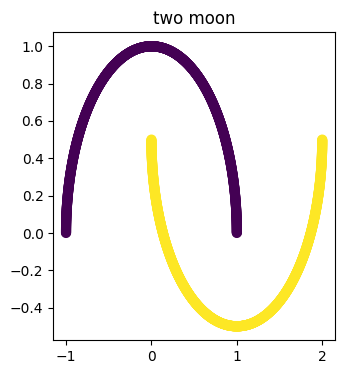

In [38]:
location, label = make_moons(n_samples=2000)
moon_data = {'location': location, 'label': label}
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.scatter(moon_data['location'][:, 0], moon_data['location'][:, 1], c=moon_data['label'], cmap=plt.cm.viridis, s=40)
plt.title('two moon')

In [71]:
X_moon_kpca = kernel_pca_nystrom_extension(moon_data['location'], samples = 500, n_components=1, kernel='rbf', gamma=15)
X_moon_kpca2 = kernel_pca_nystrom_extension(moon_data['location'], 
                                        samples = np.random.choice(np.where(moon_data['label'] == 0)[0], 500, replace=False),
                                        n_components=1, kernel='rbf', gamma=15)

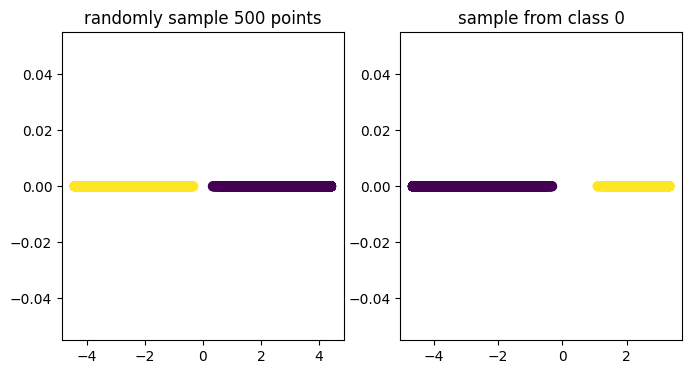

In [73]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.scatter(X_moon_kpca[:, 0], np.zeros(X_moon_kpca.shape[0]),  c=moon_data['label'], cmap=plt.cm.viridis, s=40)
plt.title('randomly sample 500 points')
plt.subplot(1,2,2)
plt.scatter(X_moon_kpca2[:, 0], np.zeros(X_moon_kpca2.shape[0]),  c=moon_data['label'], cmap=plt.cm.viridis, s=40)
plt.title('sample from class 0')
plt.savefig('kpca3.png')
plt.show()
